In [ ]:

home_directory = 'drive/My Drive'

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import random
import time
import datetime
import torch
from transformers import GPT2Tokenizer, GPT2LMHeadModel, GPT2Config, Adam, get_linear_schedule_with_warmup
from torch.utils.data import Dataset, random_split, DataLoader, RandomSampler, SequentialSampler
poem_stanza_df = pd.read_csv(home_directory + '/CS505 Data/poems.csv')
poem_stanza_df = poem_stanza_df.fillna('')

In [ ]:
RANDOM_SEED = 73
BATCH_SIZE = 3
EPOCHS = 80
MAX_LEN = 1024

In [ ]:
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

special_tokens_dict = {'bos_token': '<BOS>', 'eos_token': '<EOS>', 'pad_token': '<PAD>'}
num_added_tokens = tokenizer.add_special_tokens(special_tokens_dict)

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

# Data Preprocessing

In [ ]:
class Dataset(Dataset):

     def __init__(self, texts, encoder, model_type='gpt2', max_len=MAX_LEN):
        self.encoder = encoder
        self.token_ids = []
        self.masks = []

        for text in texts:
            encoded_text = encoder('<BOS>' + text + '<EOS>',
                                   truncation=True,
                                   max_length=max_len,
                                   padding='max_length'
                                  )

            self.token_ids.append(torch.tensor(encoded_text['input_ids']))
            self.masks.append(torch.tensor(encoded_text['attention_mask']))

    def __len__(self):
        return len(self.token_ids)

    def __getitem__(self, index):
        return self.token_ids[index], self.masks[index]


In [ ]:
poem_dataset = Dataset(poem_stanza_df['all_text'].values, tokenizer, max_length=MAX_LEN)

In [ ]:
def train_val_split(split, dataset):
    train_size = int(split * len(dataset))
    val_size = len(dataset) - train_size
    return train_size, val_size
poem_stanza_train_size, poem_stanza_val_size = train_val_split(0.8, poem_dataset)
poem_stanza_train_dataset, poem_stanza_val_dataset = random_split(poem_dataset, [poem_stanza_train_size, poem_stanza_val_size])

In [ ]:
torch.cuda.manual_seed_all(RANDOM_SEED)
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

### Data Loader

In [ ]:
train_dataloader = DataLoader(poem_stanza_train_dataset,
                              sampler=RandomSampler(poem_stanza_train_dataset),
                              batch_size=BATCH_SIZE)

val_dataloader = DataLoader(poem_stanza_val_dataset,
                            sampler=SequentialSampler(poem_stanza_val_dataset),
                            batch_size=BATCH_SIZE)

In [ ]:

def format_time(elapsed):
    return str(datetime.timedelta(seconds=int(round((elapsed)))))
learning_rate = 1e-4
eps = 1e-8
warmup_steps = 50
device = torch.device('cuda')
prompt = "<BOS>"
generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)
generated = generated.to(device)

# Model Training

In [ ]:
configuration = GPT2Config(vocab_size=len(tokenizer), n_positions=MAX_LEN).from_pretrained('gpt2', output_hidden_states=True)

AI_poetica = GPT2LMHeadModel.from_pretrained('gpt2', config=configuration)
AI_poetica.resize_token_embeddings(len(tokenizer))

AI_poetica.cuda()
optimizer = Adam(AI_poetica.parameters(), lr=learning_rate, eps=eps)

total_steps = len(train_dataloader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=warmup_steps,
                                            num_training_steps=total_steps)

start_time = time.time()
AI_poetica = AI_poetica.to(device)

for epoch_i in range(0, EPOCHS):

    print(f'Epoch {epoch_i + 1} of {EPOCHS}')

    t0 = time.time()
    total_train_loss = 0
    AI_poetica.train()

    for step, batch in enumerate(train_dataloader):

        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)

        AI_poetica.zero_grad()

        outputs = AI_poetica(b_input_ids,
                                    labels=b_labels,
                                    attention_mask=b_masks,
                                    token_type_ids=None)

        loss = outputs[0]

        batch_loss = loss.item()
        total_train_loss += batch_loss

        loss.backward()
        optimizer.step()
        scheduler.step()

    avg_train_loss = total_train_loss / len(train_dataloader)
    training_time = format_time(time.time() - t0)

    print(f'Average Training Loss: {avg_train_loss}. Epoch Training Time: {training_time}')

    t0 = time.time()

    AI_poetica.eval()

    total_eval_loss = 0
    nb_eval_steps = 0

    for batch in val_dataloader:
        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)

        with torch.no_grad():

            outputs  = AI_poetica(b_input_ids,
                                         attention_mask=b_masks,
                                         labels=b_labels)

            loss = outputs[0]

        batch_loss = loss.item()
        total_eval_loss += batch_loss

    avg_val_loss = total_eval_loss / len(val_dataloader)

    print(f'Average Validation Loss: {avg_val_loss}')
print(f'Total Training Time: {format_time(time.time()-start_time)}')
torch.save(AI_poetica.state_dict(), home_directory + '/AI_poetica.pth')


model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


# Generate Poem

In [ ]:
# AI_poetica.load_state_dict(torch.load(home_directory + '/AI_poetica.pth'))
# AI_poetica.eval()

# sample_outputs = AI_poetica.generate(
#                                 generated,
#                                 do_sample=True,
#                                 top_k=50,
#                                 max_length=MAX_LEN,
#                                 top_p=0.95,
#                                 num_return_sequences=3
#                                 )

# for i, sample_output in enumerate(sample_outputs):
#     print("{}: {}\n\n".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))

In [ ]:
model_path = home_directory + '/CS505 Data/AI_poetica.pth'
AI_poetica.load_state_dict(torch.load(model_path))
AI_poetica.eval()

sample_outputs = AI_poetica.generate(
                                generated,
                                do_sample=True,
                                top_k=50,
                                max_length=MAX_LEN,
                                top_p=0.95,
                                num_return_sequences=80
                                )


# for i, sample_output in enumerate(sample_outputs):
#     print("{}: {}\n\n".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1473: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In [ ]:
poems = [tokenizer.decode(sample_output, skip_special_tokens=True) for sample_output in sample_outputs]

In [ ]:
for i in range(2, 5):
  print(poems[i])
  print('blank')

With a serpent like tongue that spake with pleasure,   O mouth that still harbored the fire,   And drank with the flames sweet;   And like the sweet secret that Time kept,   With nought but tears and desires to unveil   So did I unveil to my lips the secret secret of the night.      But darkness, which by its own draught could neither drain nor drain   From within me a vain desire,   And from within my spirit did I finally reveal   The secret of the night:     The prolonged sleep within me that consumeth my anguish   And the hours when a mighty sleep 't will not shut   The sweet secret within me.
blank
" — "Away from remorse—from crimes I know not, save in the name of the living, and of the god-fame I."—
Whence my heart shall not mourn;
My spirit shall not mourn;
My heart shall not mourn.
My love, which is the sear,
My joy, which is the sear,
My joy will never hold dear;
My love and love, which is the sear,
My tears of love which are the tears,
My tears of love which will never kill;
M

In [ ]:
generated_poem = sample_outputs[0]  # Replace with your generated poem
generated_poem = tokenizer.decode(generated_poem, skip_special_tokens=True)
print(generated_poem)

The serpent in the mist
echoes the starry sphere,   Without any qualms:—
  I will not flatter you, either;
  Behold the ruddy strife
  Among you I will enwreathe;
  Within your grounds and deeps,
  Where sometime the beasts within,
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                

Evaluation of the result

bleu

In [ ]:
import pandas as pd
import random
from nltk.translate.bleu_score import sentence_bleu

def calculate_bleu_score(generated_poem, reference_poem):
    reference = [reference_poem.split()]
    candidate = generated_poem.split()
    score = sentence_bleu(reference, candidate)
    return score

def select_random_poem(file_path):
    """
    Select a random poem from the given CSV file.

    :param file_path: Path to the CSV file containing poems.
    :return: A tuple (title, content) of the selected poem.
    """
    df = poem_stanza_df
    random_row = df.sample().iloc[0]
    title = random_row[0]
    content = random_row[1]
    return title, content

# Usage example
poem_file_path = 'home_directory + ''/CS505 Data/poems.csv'''  # Replace with your file path
random_poem_title, random_poem_content = select_random_poem(poem_file_path)

# Now you can use random_poem_content as the reference poem for BLEU score calculation
generated_poem = generated_poem  # Replace with your generated poem
# print('generated_poem:', generated_poem)
# print()
# print('random_poem_content:', random_poem_content)
bleu_score = calculate_bleu_score(generated_poem, random_poem_content)
print(f"BLEU Score: {bleu_score}")


BLEU Score: 2.6146037884938472e-235


/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

perplexity

In [ ]:
from collections import Counter
import math

def tokenize(text):
    return text.split()

def create_unigram_model(text):
    tokens = tokenize(text)
    total_tokens = len(tokens)
    frequencies = Counter(tokens)
    probabilities = {word: freq / total_tokens for word, freq in frequencies.items()}
    return probabilities

def calculate_perplexity(text, unigram_model):
    tokens = tokenize(text)
    log_prob = sum([math.log(unigram_model.get(word, 1e-2)) for word in tokens])  # Using a small value for unknown words
    return math.exp(-log_prob / len(tokens))


def concatenate_poems(df):
    concatenated_content = ' '.join(df.iloc[:, 1])  # Assuming the second column is content
    return concatenated_content

concatenated_poem_content = concatenate_poems(poem_stanza_df)

# Assuming concatenated_poem_content is your concatenated text
unigram_model = create_unigram_model(concatenated_poem_content)

# Now calculate the perplexity of a generated poem
generated_poem = generated_poem  # Replace with your generated poem
perplexity = calculate_perplexity(generated_poem, unigram_model)
print(f"Generated Poem: {generated_poem}")
print(f"Perplexity: {perplexity}")

Generated Poem: The serpent in the mist
echoes the starry sphere,   Without any qualms:—
  I will not flatter you, either;
  Behold the ruddy strife
  Among you I will enwreathe;
  Within your grounds and deeps,
  Where sometime the beasts within,
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                

In [ ]:
def calculate_perplexities(poems, unigram_model):
    """
    Calculate the perplexity for each poem in a list of poems.

    :param poems: List of generated poems.
    :param unigram_model: The unigram model based on the concatenated poem content.
    :return: List of perplexity scores for each poem.
    """
    perplexities = []
    for poem in poems:
        perplexity = calculate_perplexity(poem, unigram_model)
        perplexities.append(perplexity)
    return perplexities

# poems is your list of 50 generated poems
perplexity_scores = calculate_perplexities(poems, unigram_model)

# # Printing the perplexity scores
# for idx, score in enumerate(perplexity_scores):
#     print(f"Perplexity of poem {idx + 1}: {score}")

In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [ ]:
pip install matplotlib

In [ ]:
import matplotlib.pyplot as plt

def plot_average_perplexity(perplexity_scores):
    """
    Plot the average perplexity against the number of samples.

    :param perplexity_scores: List of perplexity scores for each poem.
    """
    average_perplexities = []
    for i in range(1, len(perplexity_scores) + 1):
        average_perplexity = sum(perplexity_scores[:i]) / i
        average_perplexities.append(average_perplexity)

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(perplexity_scores) + 1), average_perplexities, marker='o')
    plt.title('Average Perplexity vs. Number of Samples')
    plt.xlabel('Number of Samples')
    plt.ylabel('Average Perplexity')
    plt.grid(True)
    plt.show()

# Example usage (assuming perplexity_scores is a list of perplexity scores)
# perplexity_scores = [your list of perplexity scores here]
# plot_average_perplexity(perplexity_scores)

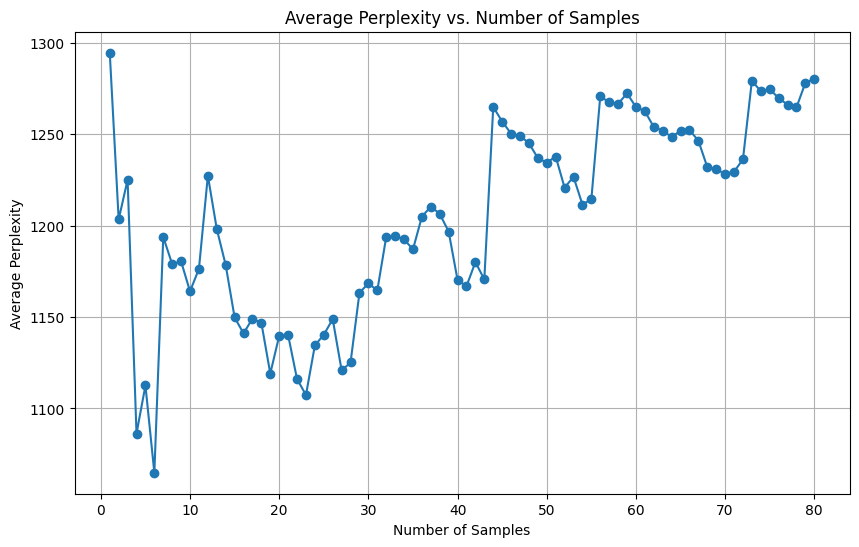

In [ ]:
# Assuming you have a list named perplexity_scores containing perplexity scores for each poem
plot_average_perplexity(perplexity_scores)

Flesch-Kincaid Readability Tests

In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [ ]:
pip install textstat

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.1/105.1 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 34.6 MB/s eta 0:00:00


In [ ]:
import textstat

def evaluate_readability(text):
    """
    Evaluate the readability of a given text using Flesch-Kincaid Readability Tests.

    :param text: The text to be evaluated.
    :return: A dictionary containing the Flesch Reading-Ease and Flesch-Kincaid Grade Level scores.
    """
    readability_scores = {
        'Flesch Reading-Ease': textstat.flesch_reading_ease(text),
        'Flesch-Kincaid Grade Level': textstat.flesch_kincaid_grade(text)
    }
    return readability_scores

# Example usage
text_to_evaluate = generated_poem # Replace this with your text
scores = evaluate_readability(text_to_evaluate)
print(scores)

{'Flesch Reading-Ease': 59.3, 'Flesch-Kincaid Grade Level': 14.2}


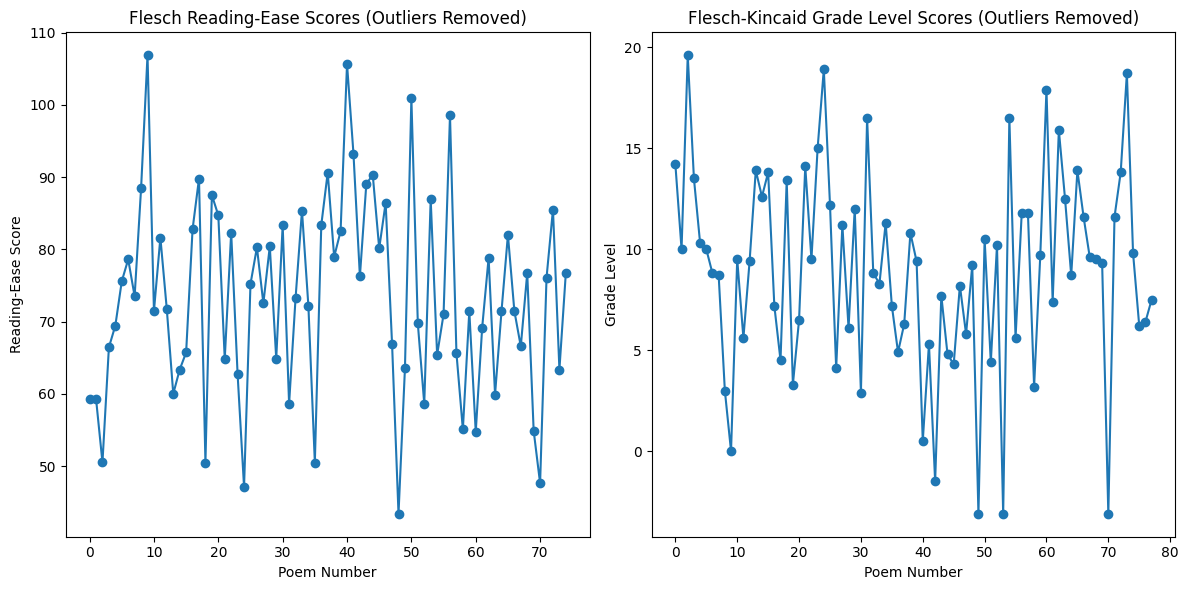

In [ ]:
import numpy as np

def remove_outliers(data):
    """
    Remove outliers from a dataset based on the interquartile range.

    :param data: List of data points.
    :return: Filtered list with outliers removed.
    """
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    iqr = q3 - q1
    lower_bound = q1 - (1.5 * iqr)
    upper_bound = q3 + (1.5 * iqr)
    return [x for x in data if lower_bound <= x <= upper_bound]

def plot_readability_scores(reading_ease_scores, grade_level_scores):
    # Removing outliers
    filtered_reading_ease_scores = remove_outliers(reading_ease_scores)
    filtered_grade_level_scores = remove_outliers(grade_level_scores)

    plt.figure(figsize=(12, 6))

    # Plotting Flesch Reading-Ease scores
    plt.subplot(1, 2, 1)
    plt.plot(filtered_reading_ease_scores, marker='o')
    plt.title('Flesch Reading-Ease Scores (Outliers Removed)')
    plt.xlabel('Poem Number')
    plt.ylabel('Reading-Ease Score')

    # Plotting Flesch-Kincaid Grade Level scores
    plt.subplot(1, 2, 2)
    plt.plot(filtered_grade_level_scores, marker='o')
    plt.title('Flesch-Kincaid Grade Level Scores (Outliers Removed)')
    plt.xlabel('Poem Number')
    plt.ylabel('Grade Level')

    plt.tight_layout()
    plt.show()

# poems is your list of 50 generated poems
reading_ease_scores, grade_level_scores = evaluate_readability(poems)
plot_readability_scores(reading_ease_scores, grade_level_scores)